# Testing transcriptions

### Spin up ollama

In [ ]:
!ollama run llama3.2:1b --keepalive 60m

In [3]:
def get_transcript(file_name: str):
    return open(file_name, "r").read()


transcript = get_transcript("data/mcclendon_tapes.txt")
print(transcript[:100])

okay so um we were talkin about that time granddaddy slipped behind the stove yeah that was in the s


## Ensure LLS is active + the model we are using to test exists

In [74]:
from llama_stack_client import LlamaStackClient

model = "llama3.2:3b"
client = LlamaStackClient(
    base_url="http://localhost:8321"
)

models = client.models.list()
assert model in [m.identifier for m in models]

INFO:httpx:HTTP Request: GET http://localhost:8321/v1/models "HTTP/1.1 200 OK"


In [50]:
client.inference.chat_completion(model_id=model, messages=[{"role": "user", "content": "What is the transcript?"}])

INFO:httpx:HTTP Request: POST http://localhost:8321/v1/inference/chat-completion "HTTP/1.1 200 OK"


ChatCompletionResponse(completion_message=CompletionMessage(content="This conversation has just begun. There is no transcript to share yet. What would you like to talk about or ask? I can summarize our conversation at the end if you'd like.", role='assistant', stop_reason='end_of_turn', tool_calls=[]), logprobs=None, metrics=[Metric(metric='prompt_tokens', value=15.0, unit=None), Metric(metric='completion_tokens', value=47.0, unit=None), Metric(metric='total_tokens', value=62.0, unit=None)])

## Determine GPU to use, if not default to CPU

In [6]:
import torch

def determine_torch_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = determine_torch_device()

In [7]:
from pyannote.audio import Pipeline
import whisper

audio = "data/sample_two_people.wav"
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization").to(determine_torch_device())

diarization = pipeline(audio)

print(diarization)

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/torch/pyan

Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.7.1. Bad things might happen unless you revert torch to 1.x.


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in /Users/sglinton/.cache/torch/pyannote/speechbrain.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/Users/sglinton/.cache/torch/pyannote/speechbrain/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /Users/sglinton/.cache/torch/pyannote/speechbrain/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/Users/sglinton/.cache/torch/pyannote/speechbrain/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /Users/sglinton/.cache/torch/pyannote/speechbrain/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/Users/sglinton/.cache/torch/pyannote/speechbrain/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in s

[ 00:00:00.030 -->  00:00:04.367] A SPEAKER_00
[ 00:00:04.485 -->  00:00:19.842] B SPEAKER_01


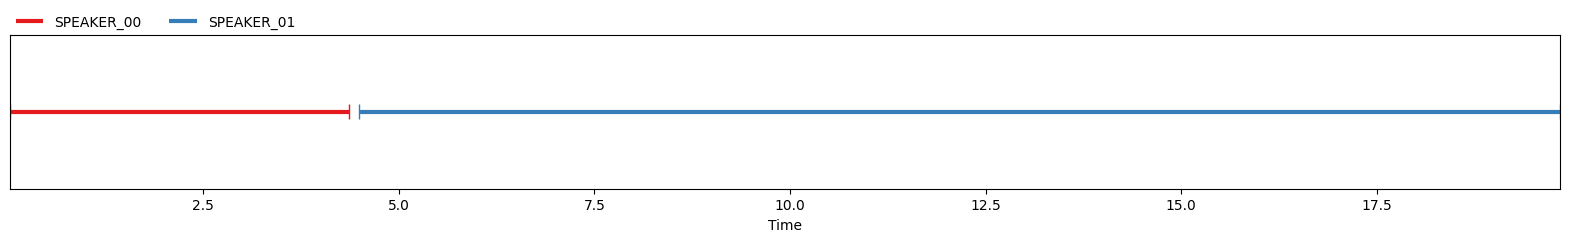

In [8]:
diarization

In [9]:
for segment in diarization.itersegments():
    print(segment)

for turn in diarization.itertracks(yield_label=True):
    print(turn)

[ 00:00:00.030 -->  00:00:04.367]
[ 00:00:04.485 -->  00:00:19.842]
(<Segment(0.0309687, 4.36784)>, 'A', 'SPEAKER_00')
(<Segment(4.48597, 19.8422)>, 'B', 'SPEAKER_01')


### Seperate speaker segments

In [10]:
def get_speaker_segments(diarization):
    segments = {}
    for turn, _, speaker in diarization.itertracks(yield_label=True):
        segments.setdefault(speaker, []).append(turn)
    return segments


diar_segments = get_speaker_segments(diarization)
diar_segments

{'SPEAKER_00': [<Segment(0.0309687, 4.36784)>],
 'SPEAKER_01': [<Segment(4.48597, 19.8422)>]}

### Ask user, "who is this?"


In [11]:
# User assigns speakers to each segment
diar_segments["jacob"] = diar_segments.pop("SPEAKER_00")
diar_segments["cameron"] = diar_segments.pop("SPEAKER_01")


diar_segments

{'jacob': [<Segment(0.0309687, 4.36784)>],
 'cameron': [<Segment(4.48597, 19.8422)>]}

In [12]:
model = whisper.load_model("base")

results = model.transcribe(audio)
results["segments"]

/Users/sglinton/dev/hub/.venv/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


[{'id': 0,
  'seek': 0,
  'start': 0.0,
  'end': 4.32,
  'text': ' Okay, so, um, we were talking about that time Granddaddy slipped behind the stove.',
  'tokens': [50364,
   1033,
   11,
   370,
   11,
   1105,
   11,
   321,
   645,
   1417,
   466,
   300,
   565,
   6757,
   20034,
   3173,
   28989,
   2261,
   264,
   19263,
   13,
   50580],
  'temperature': 0.0,
  'avg_logprob': -0.3059328445280441,
  'compression_ratio': 1.5466101694915255,
  'no_speech_prob': 0.04611587896943092},
 {'id': 1,
  'seek': 0,
  'start': 4.48,
  'end': 9.6,
  'text': ' Yeah, that was in the summer because I remember it was hot, like real hot, like stick to your chair, hot.',
  'tokens': [50588,
   865,
   11,
   300,
   390,
   294,
   264,
   4266,
   570,
   286,
   1604,
   309,
   390,
   2368,
   11,
   411,
   957,
   2368,
   11,
   411,
   2897,
   281,
   428,
   6090,
   11,
   2368,
   13,
   50844],
  'temperature': 0.0,
  'avg_logprob': -0.3059328445280441,
  'compression_ratio': 1.546

### Find the speaker based on the diarization

In [13]:
def assign_speakers(diarization_segments: dict, transcript_segments: dict):
    diarization_list = []
    for speaker, segs in diarization_segments.items():
        for seg in segs:
            diarization_list.append({'speaker': speaker, 'start': seg.start, 'end': seg.end})

    speaker_transcript_list = []
    for ts in transcript_segments:
        mid = (ts["start"] + ts["end"]) / 2
        # find the speaker that is closest to the midpoint
        speaker = None

        for seg in diarization_list:
            if seg["start"] <= mid <= seg["end"]:
                speaker = seg["speaker"]
                print(speaker)
                break
            speaker = "UNKNOWN"
        
        speaker_transcript_list.append({"speaker": speaker, "text": ts["text"], "start": ts["start"], "end": ts["end"]})
    
    return speaker_transcript_list
assigned = assign_speakers(diar_segments, results["segments"])
assigned

jacob
cameron
cameron
cameron


[{'speaker': 'jacob',
  'text': ' Okay, so, um, we were talking about that time Granddaddy slipped behind the stove.',
  'start': 0.0,
  'end': 4.32},
 {'speaker': 'cameron',
  'text': ' Yeah, that was in the summer because I remember it was hot, like real hot, like stick to your chair, hot.',
  'start': 4.48,
  'end': 9.6},
 {'speaker': 'cameron',
  'text': ' And Fio, you ran him from the backyard, right?',
  'start': 10.0,
  'end': 12.24},
 {'speaker': 'cameron',
  'text': " You had their muddy boots and mama yelled, not in my kitchen, boy, but you didn't even hear her because you saw him on the floor.",
  'start': 12.72,
  'end': 19.68}]

In [14]:
def rebuild_transcript(assigned_speakers: list):
    transcript = ""
    last_speaker = None
    for speaker_data in assigned_speakers:
        speaker = speaker_data["speaker"]
        if speaker != last_speaker:
            transcript += f"\n{speaker}: "
        transcript += speaker_data["text"] + " "
        last_speaker = speaker
    return transcript.strip()


r_transcript = rebuild_transcript(assigned)
r_transcript

"jacob:  Okay, so, um, we were talking about that time Granddaddy slipped behind the stove. \ncameron:  Yeah, that was in the summer because I remember it was hot, like real hot, like stick to your chair, hot.  And Fio, you ran him from the backyard, right?  You had their muddy boots and mama yelled, not in my kitchen, boy, but you didn't even hear her because you saw him on the floor."

In [15]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

INFO:datasets:PyTorch version 2.7.1 available.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


In [21]:
def merge_chunks(transcript, max_chars=300):
    """
    Merge adjacent chunks until the chunk reaches max_chars or speaker changes.
    transcript: list of dicts [{'speaker': ..., 'text': ..., ...}]
    """
    merged = []
    current_chunk = {"speaker": None, "text": "", "start": None, "end": None}
    for entry in transcript:
        # Start new chunk if speaker changes or current chunk too long
        if (
            current_chunk["speaker"] != entry["speaker"]
            or len(current_chunk["text"]) + len(entry["text"]) > max_chars
        ):
            if current_chunk["speaker"]:
                merged.append(current_chunk.copy())
            current_chunk = {
                "speaker": entry["speaker"],
                "text": entry["text"],
                "start": entry["start"],
                "end": entry["end"],
            }
        else:
            current_chunk["text"] += " " + entry["text"]
            current_chunk["end"] = entry["end"]
    # Don't forget to add the last chunk
    if current_chunk["speaker"]:
        merged.append(current_chunk)
    return merged
merged_chunks = merge_chunks(assigned)
merged_chunks

[{'speaker': 'jacob',
  'text': ' Okay, so, um, we were talking about that time Granddaddy slipped behind the stove.',
  'start': 0.0,
  'end': 4.32},
 {'speaker': 'cameron',
  'text': " Yeah, that was in the summer because I remember it was hot, like real hot, like stick to your chair, hot.  And Fio, you ran him from the backyard, right?  You had their muddy boots and mama yelled, not in my kitchen, boy, but you didn't even hear her because you saw him on the floor.",
  'start': 4.48,
  'end': 19.68}]

In [24]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
for chunk in merged_chunks:
    chunk["embedding"] = model.encode(chunk["text"]).tolist()
merged_chunks

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[{'speaker': 'jacob',
  'text': ' Okay, so, um, we were talking about that time Granddaddy slipped behind the stove.',
  'start': 0.0,
  'end': 4.32,
  'embedding': [0.03687985613942146,
   0.07218573242425919,
   -0.031606078147888184,
   0.003955450840294361,
   -0.017403479665517807,
   -0.03887829929590225,
   0.002273143269121647,
   0.0004728688218165189,
   -0.03914864733815193,
   -0.07558505237102509,
   0.03285520523786545,
   0.07340769469738007,
   -0.008757240138947964,
   -0.020450251176953316,
   -3.621853466029279e-05,
   -0.09299337863922119,
   -0.025853067636489868,
   -0.05470428243279457,
   -0.03168981894850731,
   0.023129310458898544,
   0.008257189765572548,
   0.08070697635412216,
   0.09470941871404648,
   -0.013353965245187283,
   0.024486225098371506,
   0.06120988354086876,
   0.0346834734082222,
   0.0742507353425026,
   0.05514067783951759,
   0.07273170351982117,
   0.023806395009160042,
   -0.019037598744034767,
   -0.10669765621423721,
   0.0569484569

### Vector DB (faiss not working on 3.12?)

In [27]:
import chromadb

client = chromadb.HttpClient(host="localhost", port=8000)
collection = client.create_collection("family_stories")
for i, chunk in enumerate(merged_chunks):
    collection.add(
        ids=[f"chunk_{i}"],
        documents=[chunk["text"]],
        metadatas=[
            {"speaker": chunk["speaker"], "start": chunk["start"], "end": chunk["end"]}
        ],
        embeddings=[chunk["embedding"]],
    )


INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:httpx:HTTP Request: GET http://localhost:8000/api/v2/auth/identity "HTTP/1.1 200 OK"
INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:httpx:HTTP Request: GET http://localhost:8000/api/v2/tenants/default_tenant "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8000/api/v2/tenants/default_tenant/databases/default_database "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8000/api/v2/tenants/default_tenant/databases/default_database/collections "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8000/api/v2/pre-flight-checks "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8000/api/v2/tenants/default_tenant/databases/default_database/collections/bc221242-d20f-4d2b-afc9-0

In [38]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

query = "Tell me about granddays story behind the stove?"

query_embedding = model.encode(query).tolist()
results = collection.query(
    query_embeddings=[query_embedding],
    n_results=3,
)

results

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST http://localhost:8000/api/v2/tenants/default_tenant/databases/default_database/collections/bc221242-d20f-4d2b-afc9-0d8c95b61209/query "HTTP/1.1 200 OK"


{'ids': [['chunk_0', 'chunk_1']],
 'distances': [[0.774191, 1.5147762]],
 'embeddings': None,
 'metadatas': [[{'end': 4.32, 'speaker': 'jacob', 'start': 0.0},
   {'speaker': 'cameron', 'start': 4.48, 'end': 19.68}]],
 'documents': [[' Okay, so, um, we were talking about that time Granddaddy slipped behind the stove.',
   " Yeah, that was in the summer because I remember it was hot, like real hot, like stick to your chair, hot.  And Fio, you ran him from the backyard, right?  You had their muddy boots and mama yelled, not in my kitchen, boy, but you didn't even hear her because you saw him on the floor."]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

In [ ]:
def merge_chunks(transcript, max_chars=300):
    """
    Merge adjacent chunks until the chunk reaches max_chars or speaker changes.
    transcript: list of dicts [{'speaker': ..., 'text': ..., ...}]
    """
    merged = []
    current_chunk = {"speaker": None, "text": "", "start": None, "end": None}
    for entry in transcript:
        # Start new chunk if speaker changes or current chunk too long
        if (
            current_chunk["speaker"] != entry["speaker"]
            or len(current_chunk["text"]) + len(entry["text"]) > max_chars
        ):
            if current_chunk["speaker"]:
                merged.append(current_chunk.copy())
            current_chunk = {
                "speaker": entry["speaker"],
                "text": entry["text"],
                "start": entry["start"],
                "end": entry["end"],
            }
        else:
            current_chunk["text"] += " " + entry["text"]
            current_chunk["end"] = entry["end"]
    # Don't forget to add the last chunk
    if current_chunk["speaker"]:
        merged.append(current_chunk)
    return merged
merged_chunks = merge_chunks(assigned)
merged_chunks

[{'speaker': 'jacob',
  'text': ' Okay, so, um, we were talking about that time Granddaddy slipped behind the stove.',
  'start': 0.0,
  'end': 4.32},
 {'speaker': 'cameron',
  'text': " Yeah, that was in the summer because I remember it was hot, like real hot, like stick to your chair, hot.  And Fio, you ran him from the backyard, right?  You had their muddy boots and mama yelled, not in my kitchen, boy, but you didn't even hear her because you saw him on the floor.",
  'start': 4.48,
  'end': 19.68}]

In [78]:
docs = results["documents"][0]
metas = results["metadatas"][0]

rag_chunks = [
    f"{meta['speaker']}: {doc.strip()}"
    for meta, doc in zip(metas, docs)
]
rag_context = "\n".join(rag_chunks)

rag_context


"jacob: Okay, so, um, we were talking about that time Granddaddy slipped behind the stove.\ncameron: Yeah, that was in the summer because I remember it was hot, like real hot, like stick to your chair, hot.  And Fio, you ran him from the backyard, right?  You had their muddy boots and mama yelled, not in my kitchen, boy, but you didn't even hear her because you saw him on the floor."

In [81]:
chat = client.inference.chat_completion(
    model_id=model,
    messages=[
        {
            "role": "system",
            "content": "You are an assistant summarizing information about a family's preserved story. Don't speak in first person. Context is transcribed family members audio recordings, so it is not always clear who is speaking. Only use information from the context to answer the question.",
        },
        {
            "role": "user",
            "content": f"Context: {rag_context}\n Question: Whats the story of grandad in the kitchen?\n Answer:",
        },
    ],
)

INFO:httpx:HTTP Request: POST http://localhost:8321/v1/inference/chat-completion "HTTP/1.1 200 OK"


In [84]:
chat.completion_message.content

'According to the audio recording, it appears that Granddaddy slipped behind the stove while cooking. Cameron remembers it was a hot summer day and Fio (likely a young child) ran after Granddaddy from the backyard, wearing muddy boots, which caused Mama to yell at him not to be in the kitchen.'